In [ ]:
#!pip install keras==2.2.4
#!pip install tensorflow==1.14.0

In [5]:
import numpy as np 
import pandas as pd
import string
from tqdm import tqdm
import math,nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import  hstack
# from handFeaturesV6 import hand_features, clean, get_tokenized_lemmas, remove_stopwords
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, concatenate,Flatten,LSTM, Embedding, Input,Dropout
from keras.models import Model
# from WF_gw2v_embedding import gw2v_sentence_embeddings
from keras.callbacks import ModelCheckpoint
import os
import re
import nltk
import string
import numpy as np
from sklearn import feature_extraction
from tqdm import tqdm
from keras.models import load_model
from sklearn.model_selection import train_test_split 
import time
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout,Embedding,LSTM
from sklearn.metrics import confusion_matrix
from keras.preprocessing import sequence
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras import optimizers
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassificationReport

import warnings
warnings.filterwarnings('ignore')

In [6]:
def Congress (x):
  comment = x.lower()
  if( (' modi ' not in comment or 'modi ' not in comment) and ' bjp ' not in comment):
    comment = ' CONGRESS ' + comment
    
  elif ( 'modi '  in comment or  ' modi' in comment) :
    comment = comment.replace('modi ', ' CONGRESS RAHUL ' )
    
  return comment

In [7]:
Congress_dataset = pd.read_csv("Congress.csv", encoding="ISO-8859-1")
Congress_dataset = Congress_dataset.rename(columns = {'ï»¿commentText':'commentText'})

Congress_dataset['commentText'] =  Congress_dataset['commentText'].apply(lambda x : Congress(x))

In [8]:
Bjp_dataset = pd.read_csv("BJP.csv", encoding="ISO-8859-1")

In [9]:
def BJP (x): 
  comment = x.lower()
  if( (' rahul ' not in comment and 'rahul ' not in comment) and ' congress ' not in comment and ' cong ' not in comment):
    comment = ' BJP ' + comment
  elif ('rahul' in comment or ' rahul' in comment or 'rahul ' in comment):
    comment = comment.replace('rahul', ' BJP MODI ' )

  return comment

In [10]:
Bjp_dataset['commentText'] =  Bjp_dataset['commentText'].apply(lambda x : BJP(x))

In [11]:
Congress_dataset["newLabel"] = 0
Congress_dataset.columns

Index(['commentText', 'Label', 'newLabel'], dtype='object')

In [12]:
Congress_dataset.newLabel[Congress_dataset.Label == 0] =1
Congress_dataset.newLabel[Congress_dataset.Label == 1] =0

In [13]:
#dropping column label
Congress_dataset.drop(columns="Label", inplace= True)

In [14]:
#renaming column newlabel to label
Congress_dataset.rename(columns={"newLabel":"Label"} , inplace= True)

In [15]:
print(Congress_dataset.shape)
print(Bjp_dataset.shape)

(1998, 2)
(1952, 2)


In [16]:
#merging dataframes of bjp and congress
Final_df = pd.concat([Bjp_dataset, Congress_dataset])

In [17]:
print(Final_df.shape)
Final_df.columns
Final_df.reset_index(inplace= True)

(3950, 2)


In [18]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jay Dave\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to C:\Users\Jay
[nltk_data]     Dave\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Jay
[nltk_data]     Dave\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

stemmer = SnowballStemmer('english')

wordnet_lemmatizer = WordNetLemmatizer()

In [20]:
def tokenize(text):
  wordlist= []
  for word in tokenizer.tokenize(text.lower()):
      wordlist.append(word) 
    # wordlisy.append(stemmer.stem(word))
  return wordlist

In [21]:
def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]

In [22]:
titles=  Final_df['commentText']
titles=remove_stopwords(titles)
labels= Final_df['Label'].tolist()

In [23]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [37]:
def mlp():
    vectorizer = TfidfVectorizer(tokenizer = tokenize, max_features = 5300, ngram_range=(1,4), lowercase= True)
    tfdf = vectorizer.fit_transform(titles)
    words = vectorizer.get_feature_names()
    y= Final_df.Label
    X_train, X_test, y_train, y_test = train_test_split( tfdf, y, test_size=0.25, random_state=42)
    mlp = Sequential()
    mlp.add(Dense(500, input_dim=5300, activation='relu'))
    mlp.add(Dropout(0.1))
    mlp.add(Dense(550, activation='relu'))
    mlp.add(Dropout(0.1))

    mlp.add(Dense(100, activation='relu'))
    mlp.add(Dropout(0.1))

    mlp.add(Dense(10, activation='relu'))
    mlp.add(Dropout(0.1))
    mlp.add(Dense(1, activation='sigmoid'))

    opt =optimizers.adamax(lr=0.001)
    mlp.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    start_time = time.clock()


    # Fit the model
    mlp.fit(X_train, y_train, epochs=20, batch_size=150,verbose=1,validation_split=0.1, shuffle=True )

    from sklearn.metrics import roc_curve
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, mlp.predict(X_test))

    from sklearn.metrics import roc_auc_score, auc
    from matplotlib import pyplot

    print("AUC: "+ str(auc(fpr_keras, tpr_keras)))

    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr_keras, tpr_keras, marker='.')
    # show the plot
    pyplot.show()

    prediction= mlp.predict(X_test)
    YClass= np.zeros((len(prediction)))
    acc,scor= mlp.evaluate(X_test,y_test)
    print(acc, scor)
    mlp.save("model_mlp.h5")

    for i in range(len(prediction)):
        if prediction[i][0]>=0.5:
            YClass[i]=1
        else:
            YClass[i]=0
    print("AUC: "+ str(auc(fpr_keras, tpr_keras)))
    matrix1 = confusion_matrix(y_test, YClass)
    plot_confusion_matrix(cm=matrix1,target_names=['Possitive', 'Negative'])
    #Classification Report
    print("Classification Report : ")
    target_names = ['Possitive','Negative']
    print(classification_report(y_test, YClass, target_names=target_names))

Train on 2665 samples, validate on 297 samples
Epoch 1/20
2665/2665 [==============================] - ETA: 44s - loss: 0.6929 - acc: 0.50 - ETA: 21s - loss: 0.6930 - acc: 0.49 - ETA: 14s - loss: 0.6925 - acc: 0.51 - ETA: 10s - loss: 0.6926 - acc: 0.50 - ETA: 8s - loss: 0.6922 - acc: 0.5080 - ETA: 6s - loss: 0.6918 - acc: 0.512 - ETA: 5s - loss: 0.6914 - acc: 0.512 - ETA: 4s - loss: 0.6909 - acc: 0.515 - ETA: 3s - loss: 0.6906 - acc: 0.513 - ETA: 2s - loss: 0.6906 - acc: 0.508 - ETA: 2s - loss: 0.6902 - acc: 0.507 - ETA: 1s - loss: 0.6898 - acc: 0.506 - ETA: 1s - loss: 0.6896 - acc: 0.506 - ETA: 1s - loss: 0.6888 - acc: 0.513 - ETA: 0s - loss: 0.6883 - acc: 0.516 - ETA: 0s - loss: 0.6874 - acc: 0.521 - ETA: 0s - loss: 0.6873 - acc: 0.521 - 5s 2ms/step - loss: 0.6864 - acc: 0.5272 - val_loss: 0.6793 - val_acc: 0.5354
Epoch 2/20
2665/2665 [==============================] - ETA: 1s - loss: 0.6636 - acc: 0.653 - ETA: 1s - loss: 0.6618 - acc: 0.643 - ETA: 1s - loss: 0.6603 - acc: 0.642 - ET

2665/2665 [==============================] - ETA: 1s - loss: 0.0776 - acc: 0.966 - ETA: 1s - loss: 0.0806 - acc: 0.963 - ETA: 1s - loss: 0.0976 - acc: 0.964 - ETA: 1s - loss: 0.0830 - acc: 0.970 - ETA: 1s - loss: 0.0760 - acc: 0.970 - ETA: 1s - loss: 0.0715 - acc: 0.971 - ETA: 1s - loss: 0.0673 - acc: 0.974 - ETA: 0s - loss: 0.0645 - acc: 0.975 - ETA: 0s - loss: 0.0625 - acc: 0.977 - ETA: 0s - loss: 0.0642 - acc: 0.977 - ETA: 0s - loss: 0.0683 - acc: 0.975 - ETA: 0s - loss: 0.0754 - acc: 0.975 - ETA: 0s - loss: 0.0768 - acc: 0.974 - ETA: 0s - loss: 0.0747 - acc: 0.975 - ETA: 0s - loss: 0.0730 - acc: 0.975 - ETA: 0s - loss: 0.0725 - acc: 0.975 - ETA: 0s - loss: 0.0722 - acc: 0.975 - 2s 719us/step - loss: 0.0745 - acc: 0.9745 - val_loss: 0.8211 - val_acc: 0.7609
Epoch 12/20
2665/2665 [==============================] - ETA: 1s - loss: 0.0405 - acc: 0.986 - ETA: 1s - loss: 0.0453 - acc: 0.986 - ETA: 1s - loss: 0.0580 - acc: 0.980 - ETA: 1s - loss: 0.0591 - acc: 0.980 - ETA: 1s - loss: 0.06

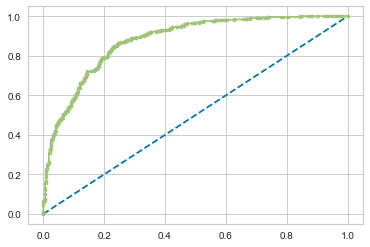

988/988 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 354us/step
0.7886893300392367 0.7975708504437435
AUC: 0.8790386033931644


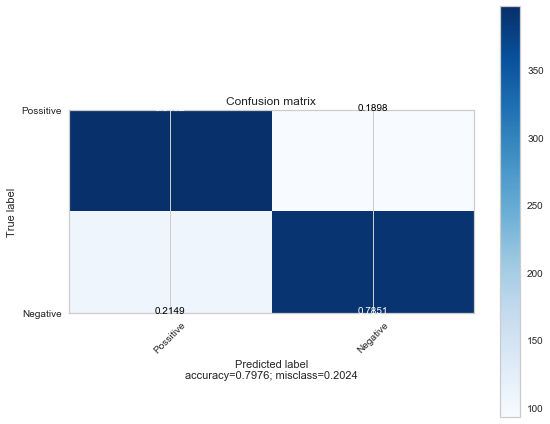

Classification Report : 
              precision    recall  f1-score   support

   Possitive       0.79      0.81      0.80       490
    Negative       0.81      0.79      0.80       498

    accuracy                           0.80       988
   macro avg       0.80      0.80      0.80       988
weighted avg       0.80      0.80      0.80       988



In [39]:
mlp()

In [23]:
def cnn(titles):
    tfidf_vect = TfidfVectorizer(ngram_range=(1,4),tokenizer = tokenize, max_features=5300)
    tfidf_vect.fit(titles)
    titleFeatures= tfidf_vect.transform(titles).toarray()
    print(titleFeatures.shape)
    
    labels= Final_df['Label'].tolist()


    train_feat, test_feat, train_labels, test_labels= train_test_split(titleFeatures,labels,test_size= 0.25,shuffle=True,random_state=42)

    featureLen= train_feat.shape[1]


    model= Sequential()
    model.add(Dense(300,activation='relu', input_shape=(featureLen,)))
    model.add(Dense(160,activation='relu'))
    model.add(Dense(80,activation='relu'))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))



    filepath=r"Hinglish-tfidf_cnn_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    callbacks_list = [checkpoint]

    model.compile(loss = 'mse', optimizer='adam',metrics = ['accuracy'])

    model.summary()
   

    model.fit(train_feat,train_labels,epochs=30,batch_size=150,verbose=1,validation_split=0.1, shuffle=True,callbacks=callbacks_list)

    from sklearn.metrics import roc_curve
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, model.predict(test_feat))

    from sklearn.metrics import roc_auc_score, auc
    from matplotlib import pyplot

    print("AUC: "+ str(auc(fpr_keras, tpr_keras)))

    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr_keras, tpr_keras, marker='.')
    # show the plot
    pyplot.show()

    prediction= model.predict(test_feat)
    YClass= np.zeros((len(prediction)))


    acc,scor= model.evaluate(test_feat,test_labels)

    print(acc, scor)
    
    #model.save("model_cnn.h5")

    for i in range(len(prediction)):
        if prediction[i][0]>=0.5:
            YClass[i]=1
        else:
            YClass[i]=0

    matrix1 = confusion_matrix(test_labels, YClass)
    plot_confusion_matrix(cm=matrix1,target_names=['Possitive', 'Negative'])
    #Classification Report
    print("Classification Report : ")
    target_names = ['Possitive','Negative']
    print(classification_report(test_labels, YClass, target_names=target_names))

(3950, 5300)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 300)               1590300   
_________________________________________________________________
dense_80 (Dense)             (None, 160)               48160     
_________________________________________________________________
dense_81 (Dense)             (None, 80)                12880     
_________________________________________________________________
dense_82 (Dense)             (None, 50)                4050      
_________________________________________________________________
dense_83 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 21        
Total params: 1,656,431
Trainable params: 1,656,431
Non-trainable params: 0
_____________________________________________________

2665/2665 [==============================] - ETA: 0s - loss: 0.0157 - acc: 0.986 - ETA: 0s - loss: 0.0121 - acc: 0.990 - ETA: 0s - loss: 0.0127 - acc: 0.986 - ETA: 0s - loss: 0.0113 - acc: 0.988 - ETA: 0s - loss: 0.0099 - acc: 0.989 - ETA: 0s - loss: 0.0100 - acc: 0.988 - ETA: 0s - loss: 0.0114 - acc: 0.986 - ETA: 0s - loss: 0.0101 - acc: 0.988 - ETA: 0s - loss: 0.0093 - acc: 0.988 - ETA: 0s - loss: 0.0122 - acc: 0.985 - ETA: 0s - loss: 0.0125 - acc: 0.985 - ETA: 0s - loss: 0.0126 - acc: 0.985 - ETA: 0s - loss: 0.0126 - acc: 0.985 - ETA: 0s - loss: 0.0133 - acc: 0.984 - ETA: 0s - loss: 0.0133 - acc: 0.984 - ETA: 0s - loss: 0.0140 - acc: 0.983 - ETA: 0s - loss: 0.0137 - acc: 0.983 - 1s 466us/step - loss: 0.0133 - acc: 0.9842 - val_loss: 0.2049 - val_acc: 0.7643

Epoch 00018: val_acc did not improve from 0.77104
Epoch 19/30
2665/2665 [==============================] - ETA: 1s - loss: 0.0025 - acc: 0.993 - ETA: 0s - loss: 0.0064 - acc: 0.990 - ETA: 1s - loss: 0.0067 - acc: 0.991 - ETA: 0s

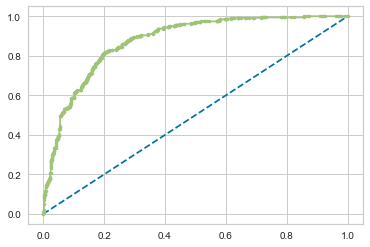

988/988 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 328us/step
0.16534682257696684 0.8036437249376707


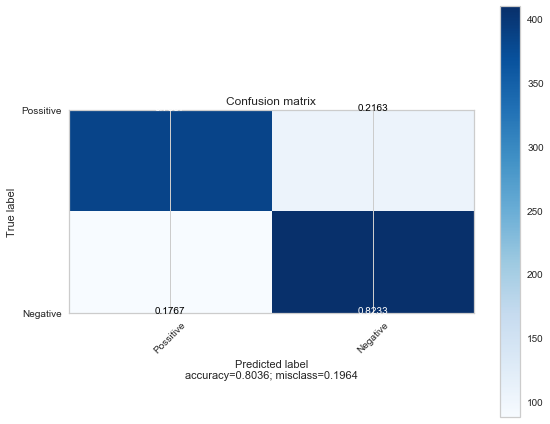

Classification Report : 
              precision    recall  f1-score   support

   Possitive       0.81      0.78      0.80       490
    Negative       0.79      0.82      0.81       498

    accuracy                           0.80       988
   macro avg       0.80      0.80      0.80       988
weighted avg       0.80      0.80      0.80       988



In [38]:
cnn(titles)

In [44]:
def cnn_lstm():
    max_fatures = 1000 #or vocab size
    #Keras tokenizer 
    tokenizer = Tokenizer(nb_words=max_fatures, split=' ', )
    tokenizer.fit_on_texts(titles)
    X1 = tokenizer.texts_to_sequences(titles)
    X1 = sequence.pad_sequences(X1, maxlen= max_fatures)
    Y1 = (Final_df.Label).values #pd.get_dummies
    #Train test split
    X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
    print(X1_train.shape,Y1_train.shape)
    print(X1_test.shape,Y1_test.shape)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    embed_dim = 150
    lstm_out = 500
    model = Sequential() 
    model.add(Embedding(max_fatures, embed_dim,input_length = X1.shape[1], dropout=0.1))
    model.add(Conv1D(64, 5, activation='relu')) # 128 * 128 5 FILTERS i/p - 10 filters +1 = 491
    model.add(MaxPooling1D(pool_size=4)) # 4 LAYERS OF POOLING
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(64,  return_sequences = False))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    start_time = time.clock()
    model.save('cnn_lstm.h5')
    model.fit(X1_train,Y1_train,batch_size=35,epochs=15,verbose=1)
    print (time.clock() - start_time, "seconds")
    from sklearn.metrics import roc_curve
    y_pred_keras = model.predict(X1_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y1_test, model.predict(X1_test))
    from sklearn.metrics import roc_auc_score
    from matplotlib import pyplot
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr_keras, tpr_keras, marker='.')
    from sklearn.metrics import roc_auc_score, auc
    from matplotlib import pyplot

    print("AUC: "+ str(auc(fpr_keras, tpr_keras)))
    # show the plot
    pyplot.show()
    #Confusion Matrix
    prediction= model.predict(X1_test)
    YClass= np.zeros((len(prediction)))
    acc,scor= model.evaluate(X1_test,Y1_test)
    acc, scor
    model.save("model_cnn.h5")

    for i in range(len(prediction)):
        if prediction[i][0]>=0.5:
            YClass[i]=1
        else:
            YClass[i]=0
    print("AUC: "+ str(auc(fpr_keras, tpr_keras)))
    matrix1 = confusion_matrix(Y1_test, YClass)
    plot_confusion_matrix(cm=matrix1,target_names=['Possitive', 'Negative'])
    
    #Classification Report
    print("Classification Report : ")
    target_names = ['Possitive','Negative']
    print(classification_report(Y1_test, YClass, target_names=target_names))

(2962, 1000) (2962,)
(988, 1000) (988,)
Found 5824 unique tokens.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 150)         150000    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 996, 64)           48064     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 248, 64)           8256      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_44 (

2962/2962 [==============================] - ETA: 34s - loss: 0.3853 - acc: 0.82 - ETA: 33s - loss: 0.4160 - acc: 0.87 - ETA: 30s - loss: 0.3877 - acc: 0.86 - ETA: 28s - loss: 0.3646 - acc: 0.86 - ETA: 27s - loss: 0.3626 - acc: 0.85 - ETA: 26s - loss: 0.3495 - acc: 0.85 - ETA: 26s - loss: 0.3376 - acc: 0.86 - ETA: 26s - loss: 0.3645 - acc: 0.84 - ETA: 25s - loss: 0.3609 - acc: 0.84 - ETA: 24s - loss: 0.3556 - acc: 0.84 - ETA: 24s - loss: 0.3371 - acc: 0.85 - ETA: 24s - loss: 0.3401 - acc: 0.85 - ETA: 24s - loss: 0.3455 - acc: 0.85 - ETA: 24s - loss: 0.3445 - acc: 0.85 - ETA: 23s - loss: 0.3363 - acc: 0.85 - ETA: 23s - loss: 0.3377 - acc: 0.85 - ETA: 23s - loss: 0.3362 - acc: 0.86 - ETA: 23s - loss: 0.3460 - acc: 0.85 - ETA: 22s - loss: 0.3444 - acc: 0.86 - ETA: 21s - loss: 0.3331 - acc: 0.86 - ETA: 21s - loss: 0.3240 - acc: 0.87 - ETA: 21s - loss: 0.3182 - acc: 0.87 - ETA: 20s - loss: 0.3149 - acc: 0.87 - ETA: 20s - loss: 0.3076 - acc: 0.87 - ETA: 20s - loss: 0.3073 - acc: 0.87 - ETA: 

2962/2962 [==============================] - ETA: 20s - loss: 0.0880 - acc: 1.00 - ETA: 19s - loss: 0.1381 - acc: 0.98 - ETA: 20s - loss: 0.1265 - acc: 0.98 - ETA: 21s - loss: 0.1324 - acc: 0.97 - ETA: 24s - loss: 0.1436 - acc: 0.97 - ETA: 23s - loss: 0.1344 - acc: 0.97 - ETA: 23s - loss: 0.1298 - acc: 0.97 - ETA: 23s - loss: 0.1403 - acc: 0.97 - ETA: 23s - loss: 0.1421 - acc: 0.96 - ETA: 23s - loss: 0.1364 - acc: 0.96 - ETA: 23s - loss: 0.1326 - acc: 0.96 - ETA: 23s - loss: 0.1393 - acc: 0.96 - ETA: 22s - loss: 0.1555 - acc: 0.95 - ETA: 22s - loss: 0.1512 - acc: 0.95 - ETA: 22s - loss: 0.1545 - acc: 0.95 - ETA: 21s - loss: 0.1521 - acc: 0.95 - ETA: 21s - loss: 0.1512 - acc: 0.95 - ETA: 21s - loss: 0.1518 - acc: 0.95 - ETA: 20s - loss: 0.1482 - acc: 0.95 - ETA: 20s - loss: 0.1460 - acc: 0.95 - ETA: 20s - loss: 0.1431 - acc: 0.95 - ETA: 19s - loss: 0.1448 - acc: 0.95 - ETA: 19s - loss: 0.1467 - acc: 0.95 - ETA: 19s - loss: 0.1446 - acc: 0.95 - ETA: 18s - loss: 0.1443 - acc: 0.95 - ETA: 

2962/2962 [==============================] - ETA: 20s - loss: 0.1310 - acc: 0.97 - ETA: 20s - loss: 0.0782 - acc: 0.98 - ETA: 22s - loss: 0.1071 - acc: 0.98 - ETA: 24s - loss: 0.1002 - acc: 0.97 - ETA: 23s - loss: 0.0947 - acc: 0.97 - ETA: 22s - loss: 0.0827 - acc: 0.98 - ETA: 23s - loss: 0.0743 - acc: 0.98 - ETA: 23s - loss: 0.0728 - acc: 0.97 - ETA: 22s - loss: 0.0687 - acc: 0.97 - ETA: 21s - loss: 0.0789 - acc: 0.97 - ETA: 21s - loss: 0.0822 - acc: 0.96 - ETA: 21s - loss: 0.0833 - acc: 0.96 - ETA: 20s - loss: 0.0855 - acc: 0.96 - ETA: 20s - loss: 0.0849 - acc: 0.96 - ETA: 20s - loss: 0.0898 - acc: 0.96 - ETA: 19s - loss: 0.0848 - acc: 0.96 - ETA: 19s - loss: 0.0813 - acc: 0.96 - ETA: 19s - loss: 0.0799 - acc: 0.96 - ETA: 18s - loss: 0.0800 - acc: 0.96 - ETA: 18s - loss: 0.0778 - acc: 0.97 - ETA: 18s - loss: 0.0746 - acc: 0.97 - ETA: 18s - loss: 0.0745 - acc: 0.97 - ETA: 17s - loss: 0.0722 - acc: 0.97 - ETA: 17s - loss: 0.0712 - acc: 0.97 - ETA: 17s - loss: 0.0736 - acc: 0.97 - ETA: 

2962/2962 [==============================] - ETA: 23s - loss: 0.1793 - acc: 0.91 - ETA: 29s - loss: 0.1414 - acc: 0.94 - ETA: 29s - loss: 0.1223 - acc: 0.95 - ETA: 27s - loss: 0.1008 - acc: 0.95 - ETA: 26s - loss: 0.0888 - acc: 0.96 - ETA: 25s - loss: 0.0900 - acc: 0.95 - ETA: 25s - loss: 0.0842 - acc: 0.96 - ETA: 24s - loss: 0.0867 - acc: 0.96 - ETA: 24s - loss: 0.0874 - acc: 0.96 - ETA: 25s - loss: 0.0847 - acc: 0.96 - ETA: 24s - loss: 0.0805 - acc: 0.96 - ETA: 23s - loss: 0.0786 - acc: 0.97 - ETA: 23s - loss: 0.0804 - acc: 0.96 - ETA: 23s - loss: 0.0761 - acc: 0.97 - ETA: 22s - loss: 0.0767 - acc: 0.96 - ETA: 22s - loss: 0.0848 - acc: 0.96 - ETA: 21s - loss: 0.0818 - acc: 0.96 - ETA: 21s - loss: 0.0807 - acc: 0.96 - ETA: 20s - loss: 0.0849 - acc: 0.96 - ETA: 20s - loss: 0.0823 - acc: 0.96 - ETA: 20s - loss: 0.0801 - acc: 0.96 - ETA: 20s - loss: 0.0825 - acc: 0.96 - ETA: 19s - loss: 0.0871 - acc: 0.96 - ETA: 19s - loss: 0.0853 - acc: 0.96 - ETA: 19s - loss: 0.0854 - acc: 0.96 - ETA: 

2962/2962 [==============================] - ETA: 25s - loss: 0.0480 - acc: 0.97 - ETA: 28s - loss: 0.0295 - acc: 0.98 - ETA: 28s - loss: 0.0462 - acc: 0.98 - ETA: 26s - loss: 0.0562 - acc: 0.97 - ETA: 25s - loss: 0.0636 - acc: 0.97 - ETA: 24s - loss: 0.0616 - acc: 0.97 - ETA: 24s - loss: 0.0578 - acc: 0.97 - ETA: 25s - loss: 0.0534 - acc: 0.98 - ETA: 24s - loss: 0.0522 - acc: 0.98 - ETA: 24s - loss: 0.0512 - acc: 0.98 - ETA: 23s - loss: 0.0538 - acc: 0.98 - ETA: 23s - loss: 0.0600 - acc: 0.97 - ETA: 23s - loss: 0.0578 - acc: 0.97 - ETA: 22s - loss: 0.0566 - acc: 0.97 - ETA: 22s - loss: 0.0533 - acc: 0.97 - ETA: 21s - loss: 0.0651 - acc: 0.97 - ETA: 21s - loss: 0.0638 - acc: 0.97 - ETA: 21s - loss: 0.0614 - acc: 0.97 - ETA: 21s - loss: 0.0617 - acc: 0.97 - ETA: 20s - loss: 0.0610 - acc: 0.97 - ETA: 20s - loss: 0.0586 - acc: 0.97 - ETA: 20s - loss: 0.0597 - acc: 0.97 - ETA: 19s - loss: 0.0602 - acc: 0.97 - ETA: 19s - loss: 0.0580 - acc: 0.97 - ETA: 19s - loss: 0.0565 - acc: 0.97 - ETA: 

2962/2962 [==============================] - ETA: 26s - loss: 0.1209 - acc: 0.94 - ETA: 24s - loss: 0.0767 - acc: 0.95 - ETA: 23s - loss: 0.0569 - acc: 0.97 - ETA: 24s - loss: 0.0719 - acc: 0.97 - ETA: 25s - loss: 0.0659 - acc: 0.97 - ETA: 24s - loss: 0.0566 - acc: 0.97 - ETA: 24s - loss: 0.0499 - acc: 0.97 - ETA: 23s - loss: 0.0482 - acc: 0.97 - ETA: 23s - loss: 0.0431 - acc: 0.98 - ETA: 23s - loss: 0.0404 - acc: 0.98 - ETA: 23s - loss: 0.0480 - acc: 0.98 - ETA: 22s - loss: 0.0463 - acc: 0.98 - ETA: 22s - loss: 0.0503 - acc: 0.98 - ETA: 21s - loss: 0.0495 - acc: 0.97 - ETA: 21s - loss: 0.0597 - acc: 0.97 - ETA: 21s - loss: 0.0576 - acc: 0.97 - ETA: 21s - loss: 0.0631 - acc: 0.97 - ETA: 20s - loss: 0.0610 - acc: 0.97 - ETA: 20s - loss: 0.0627 - acc: 0.97 - ETA: 19s - loss: 0.0614 - acc: 0.97 - ETA: 19s - loss: 0.0598 - acc: 0.97 - ETA: 19s - loss: 0.0615 - acc: 0.97 - ETA: 18s - loss: 0.0623 - acc: 0.97 - ETA: 18s - loss: 0.0619 - acc: 0.97 - ETA: 18s - loss: 0.0596 - acc: 0.97 - ETA: 

2962/2962 [==============================] - ETA: 25s - loss: 0.0076 - acc: 1.00 - ETA: 22s - loss: 0.0872 - acc: 0.94 - ETA: 22s - loss: 0.0658 - acc: 0.96 - ETA: 24s - loss: 0.0588 - acc: 0.97 - ETA: 26s - loss: 0.0800 - acc: 0.96 - ETA: 25s - loss: 0.0753 - acc: 0.96 - ETA: 24s - loss: 0.0657 - acc: 0.97 - ETA: 23s - loss: 0.0615 - acc: 0.97 - ETA: 24s - loss: 0.0571 - acc: 0.97 - ETA: 24s - loss: 0.0550 - acc: 0.98 - ETA: 23s - loss: 0.0584 - acc: 0.97 - ETA: 23s - loss: 0.0600 - acc: 0.97 - ETA: 23s - loss: 0.0577 - acc: 0.97 - ETA: 23s - loss: 0.0563 - acc: 0.97 - ETA: 22s - loss: 0.0636 - acc: 0.96 - ETA: 22s - loss: 0.0614 - acc: 0.96 - ETA: 21s - loss: 0.0629 - acc: 0.96 - ETA: 21s - loss: 0.0661 - acc: 0.96 - ETA: 21s - loss: 0.0710 - acc: 0.96 - ETA: 20s - loss: 0.0692 - acc: 0.96 - ETA: 20s - loss: 0.0670 - acc: 0.96 - ETA: 20s - loss: 0.0667 - acc: 0.96 - ETA: 19s - loss: 0.0657 - acc: 0.96 - ETA: 19s - loss: 0.0651 - acc: 0.96 - ETA: 19s - loss: 0.0678 - acc: 0.96 - ETA: 

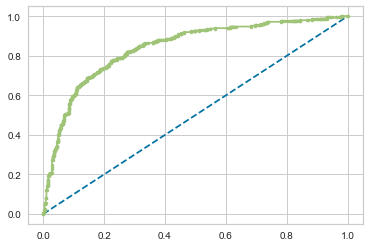

988/988 [==============================] - ETA: 40 - ETA: 20 - ETA: 14 - ETA: 10 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 4ms/step
AUC: 0.8423858700106549


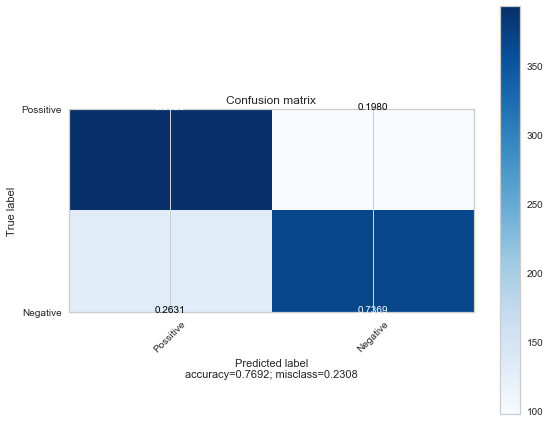

Classification Report : 
              precision    recall  f1-score   support

   Possitive       0.75      0.80      0.78       490
    Negative       0.79      0.74      0.76       498

    accuracy                           0.77       988
   macro avg       0.77      0.77      0.77       988
weighted avg       0.77      0.77      0.77       988



In [46]:
cnn_lstm()